### Імпортування бібліотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import netCDF4 as nc
from sklearn.linear_model import LinearRegression
import datetime 

2024-06-13 22:38:25.170701: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-13 22:38:25.272031: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-13 22:38:25.272154: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-13 22:38:25.285902: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-13 22:38:25.325252: I tensorflow/core/platform/cpu_feature_guar

### Перевірка застосування графічного процесора

In [2]:
#check if GPU is available
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-06-13 22:38:26.823059: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-13 22:38:26.959596: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-13 22:38:26.959645: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


### Завантажження данних у словник

In [3]:

data = {
    year: {
            "climate": nc.Dataset("data/train/" + year + "/climate.nc"),
            "polution": nc.Dataset("data/train/" + year + "/polution.nc"),
        }
    for year in ["2021", "2022", "2023"]
}

In [4]:
test = {
        "climate": nc.Dataset("data/test/" + "/climate.nc"),
        "polution": nc.Dataset("data/test/" + "/polution.nc"),
}

#### Кількість географічних точок на кліматичних данних і на данних про викидів різниться. 
#### Знаходжу спільні точки

In [5]:
pol_lat_2021 = np.array(data["2021"]["polution"].variables["latitude"][: :-1])
climate_lat_2021 = np.array(data["2021"]["climate"].variables['lat'][:])
sorter = np.argsort(pol_lat_2021)
lats = -1 - np.searchsorted(pol_lat_2021, climate_lat_2021, sorter=sorter)


pol_lon_2021 = np.array(data["2021"]["polution"].variables["longitude"][:])
climate_lon_2021 = np.array(data["2021"]["climate"].variables['lon'][:])
sorter = np.argsort(pol_lon_2021)
lons = np.searchsorted(pol_lon_2021, climate_lon_2021, sorter=sorter)

### Завантаження данних у множину датафреймів

Одразу позбуваємось даних про вітер на висоті 50 метрів

In [6]:
start_date = datetime.date(2021, 1, 1); end_date = datetime.date(2023, 12, 31)
time = [start_date + datetime.timedelta(days=i) for i in range((end_date - start_date).days + 1)]

train_data = {}

atributes_climate = list(data["2021"]["climate"].variables.keys())[:-3]
atributes_climate.remove("WS50M")
atributes_climate.remove("WD50M")
atributes_polution = list(data["2021"]["polution"].variables.keys())[4:]

for i in range(len(lats)):
    for j in range(len(lons)):

        i_p = lats[i]
        j_p = lons[j]

        _data = {
            atribute: np.array(data["2021"]["climate"].variables[atribute][:, i, j])
            for atribute in atributes_climate
        }

        for atribute in atributes_polution:
            _data[atribute] = np.array(data["2021"]["polution"].variables[atribute][:, 0, i_p, j_p])


        _data["time"] = time

        for year in ["2022", "2023"]:
            for atribute in atributes_climate:
                _data[atribute] = np.append(_data[atribute], np.array(data[year]["climate"].variables[atribute][:, 0, 0]))
            for atribute in atributes_polution:
                _data[atribute] = np.append(_data[atribute], np.array(data[year]["polution"].variables[atribute][:, 0, 0, -1]))
        
        train_data[str(float(data["2021"]["climate"].variables["lat"][i])) + "x" + str(float(data["2021"]["climate"].variables["lon"][j]))]= pd.DataFrame(_data)


In [9]:
test_data = {}
start_date = datetime.date(2024, 1, 1); end_date = datetime.date(2024, 3, 31)
time = [start_date + datetime.timedelta(days=i) for i in range((end_date - start_date).days + 1)]

for i in range(len(lats)):
    for j in range(len(lons)):

        i_p = lats[i]
        j_p = lons[j]

        _data = {
            atribute: np.array(test["climate"].variables[atribute][:, i, j])
            for atribute in atributes_climate
        }

        for atribute in atributes_polution:
            _data[atribute] = np.array(test["polution"].variables[atribute][:, 0, i_p, j_p])


        _data["time"] = time

        test_data[str(float(data["2021"]["climate"].variables["lat"][i])) + "x" + str(float(data["2021"]["climate"].variables["lon"][j]))]= pd.DataFrame(_data)


In [10]:
def norm(smth):
    smth = smth - np.min(smth)
    smth = smth/np.max(smth)
    return smth

def log_norm(smth):
    smth = np.log(1 + smth)
    return norm(smth)

In [31]:
sample = train_data["44.25x30.75"].copy()
sample_test = test_data["44.25x30.75"].copy()

In [32]:
sample["co_conc"] = log_norm(sample["co_conc"])
sample["pm10_conc"] = log_norm(sample["pm10_conc"])
sample["pm2p5_conc"] = log_norm(sample["pm2p5_conc"])

sample_test["co_conc"] = log_norm(sample_test["co_conc"])
sample_test["pm10_conc"] = log_norm(sample_test["pm10_conc"])
sample_test["pm2p5_conc"] = log_norm(sample_test["pm2p5_conc"])


for i in atributes_climate:
    sample[i] = log_norm(sample[i])
    sample_test[i] = log_norm(sample_test[i])
sample.head()

,ALLSKY_SFC_SW_DWN,WD10M,QV2M,PS,WS10M,T2M,co_conc,no2_conc,no_conc,o3_conc,pm10_conc,pm2p5_conc,so2_conc,time
0,0.269043,0.885004,0.454919,0.567388,0.610355,0.694195,0.297221,2.526610,0.559673,51.689259,0.535488,0.510513,1.706610,2021-01-01
1,0.449505,0.822524,0.332772,0.760872,0.449125,0.664428,0.398022,0.953106,0.170985,60.666855,0.469305,0.473638,2.275357,2021-01-02
2,0.358171,0.699968,0.439985,0.742353,0.667446,0.673773,0.297877,0.590444,0.064119,73.790909,0.676444,0.466534,0.888747,2021-01-03
3,0.190263,0.706666,0.477366,0.651348,0.548200,0.671218,0.287901,0.792554,0.099135,74.386597,0.756116,0.703906,1.191523,2021-01-04
4,0.208614,0.810651,0.474516,0.548686,0.624359,0.687206,0.344157,2.439456,0.288225,63.343338,0.730189,0.746955,1.623917,2021-01-05


In [33]:
params = sample.get(atributes_climate)
params_test = sample_test.get(atributes_climate)

co_conc = np.array(sample.get("co_conc"))
co_conc_test = np.array(sample_test.get("co_conc"))

period = 2
for i in range(period):
    co_conc[i] = sample["co_conc"][0]
    co_conc_test[i] = sample_test["co_conc"][0]

for i in range(len(co_conc) - period):
    co_conc[i + period] = sample["co_conc"][i]

for i in range(len(co_conc_test) - period):
    co_conc_test[i + period] = sample_test["co_conc"][i]

params["co_conc"] = co_conc
params_test["co_conc"] = co_conc_test

params

/tmp/ipykernel_32112/1754729415.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  params["co_conc"] = co_conc
/tmp/ipykernel_32112/1754729415.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  params_test["co_conc"] = co_conc_test


,ALLSKY_SFC_SW_DWN,WD10M,QV2M,PS,WS10M,T2M,co_conc
0,0.269043,0.885004,0.454919,0.567388,0.610355,0.694195,0.297221
1,0.449505,0.822524,0.332772,0.760872,0.449125,0.664428,0.297221
2,0.358171,0.699968,0.439985,0.742353,0.667446,0.673773,0.297221
3,0.190263,0.706666,0.477366,0.651348,0.548200,0.671218,0.398022
4,0.208614,0.810651,0.474516,0.548686,0.624359,0.687206,0.297877
...,...,...,...,...,...,...,...
1090,0.418688,0.907523,0.428538,0.643893,0.600576,0.671859,0.446626
1091,0.382203,0.734391,0.301301,0.807091,0.499211,0.634175,0.363551
1092,0.426988,0.898679,0.411348,0.666231,0.576074,0.650121,0.369335
1093,0.318726,0.903820,0.387919,0.638311,0.417023,0.620460,0.445790


In [41]:
result_test = sample_test.get("co_conc")

In [34]:
result = sample.get("co_conc")

In [35]:
model = LinearRegression().fit(params, result)
print("coeficients = ", model.coef_)
print("intercept = ", model.intercept_)
print("score = ", model.score(params, result))

coeficients =  [-0.07404688  0.02643454  0.01845236  0.038138   -0.00694526 -0.10517797
  0.564295  ]
intercept =  0.21197432
score =  0.5740118151489153


In [36]:
prediction = np.array(model.predict(params))

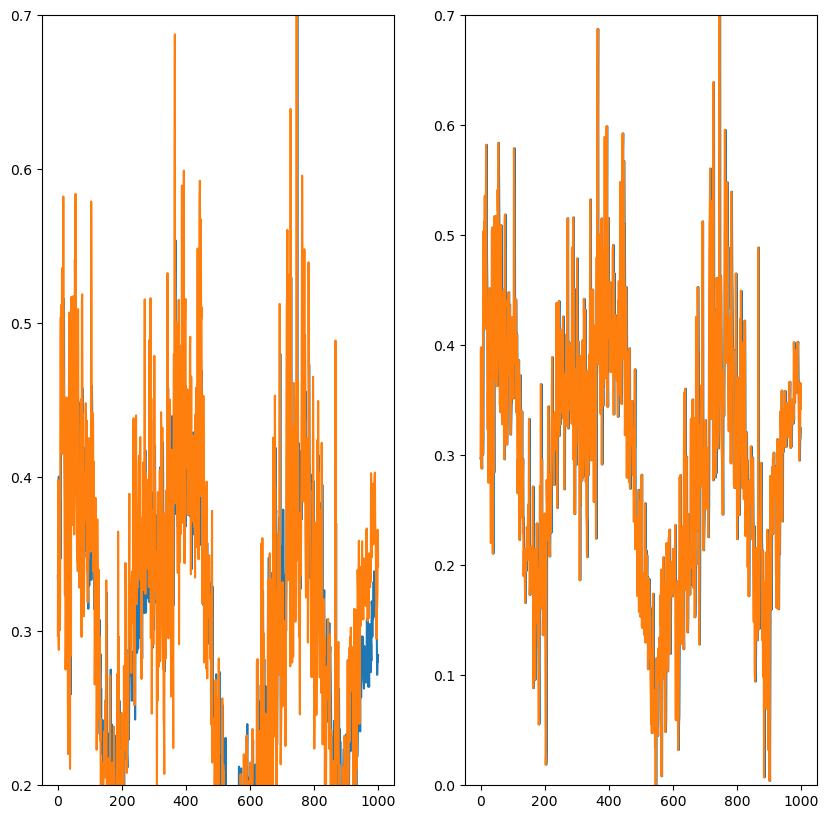

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(10,10))
n = 1000
ax=axes[0]
ax.plot(prediction[:n])
ax.plot(result[:n])
ax.set_ylim([0.2, 0.7])

ax=axes[1]
ax.plot(params["co_conc"][:n])
ax.plot(result[:n])
ax.set_ylim([0, 0.7])

plt.show()

In [38]:
print("max difference = ", np.max(np.abs(prediction - result)), "=", np.max(np.abs(prediction - result)) / np.mean(np.abs(prediction - result)), "% "
      "mean difference = " ,np.mean(np.abs(prediction - result)), "=" , np.mean(np.abs(prediction - result)) / np.mean(np.abs(prediction - result)), "% ")

max difference =  0.6267544031143188 = 10.301052501519505 % mean difference =  0.060843725 = 1.0 % 


In [39]:
print("max difference = ", np.max(np.abs(params["co_conc"] - result)), "=", np.max(np.abs(params["co_conc"] - result)) / np.mean(np.abs(params["co_conc"] - result)), "% "
      "mean difference = " ,np.mean(np.abs(params["co_conc"] - result)), "=" , np.mean(np.abs(params["co_conc"] - result)) / np.mean(np.abs(params["co_conc"] - result)), "% ")

max difference =  0.677125096321106 = 10.256321964904995 % mean difference =  0.066020265 = 1.0 % 


In [40]:
prediction_test = np.array(model.predict(params_test))

In [42]:
print("max difference = ", np.max(np.abs(prediction_test - result_test)), "=", np.max(np.abs(prediction_test - result_test)) / np.mean(np.abs(prediction_test - result_test)), "% "
      "mean difference = " ,np.mean(np.abs(prediction_test - result_test)), "=" , np.mean(np.abs(prediction_test - result_test)) / np.mean(np.abs(prediction_test - result_test)), "% ")

max difference =  0.6115081310272217 = 3.077963248003895 % mean difference =  0.19867298 = 1.0 % 


In [43]:
print("max difference = ", np.max(np.abs(params_test["co_conc"] - result_test)), "=", np.max(np.abs(params_test["co_conc"] - result_test)) / np.mean(np.abs(params_test["co_conc"] - result_test)), "% "
      "mean difference = " ,np.mean(np.abs(params_test["co_conc"] - result_test)), "=" , np.mean(np.abs(params_test["co_conc"] - result_test)) / np.mean(np.abs(params_test["co_conc"] - result_test)), "% ")

max difference =  0.6937710046768188 = 2.9452219848394856 % mean difference =  0.23555814 = 1.0 % 


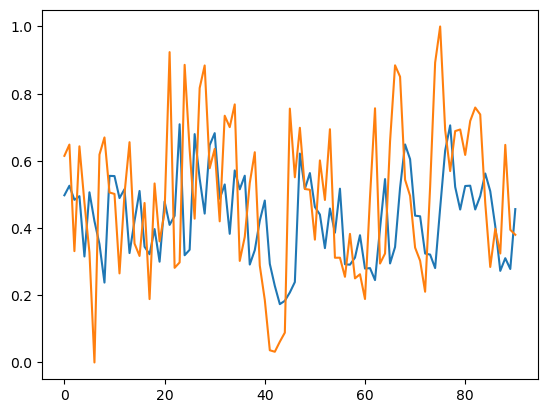

In [46]:
plt.plot(prediction_test)
plt.plot(result_test)